# 1. Import libraries

In [ ]:
!pip install -q google-generativeai transformers datasets

In [ ]:
# ===== CELL 1: SETUP =====


import google.generativeai as genai
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline
import json
import time
import pandas as pd
from datasets import load_from_disk
from tqdm import tqdm
from google.colab import drive
import torch
import matplotlib.pyplot as plt
from datasets import DatasetDict

# 2. Load model

In [ ]:
# Load data
# Mount Drive
drive.mount('/content/drive')

# Paths theo hình của bạn
PROJECT_DIR = "/content/drive/MyDrive/NLP_final/NLP_Translation_Project"
raw_datasets = load_from_disk(f"{PROJECT_DIR}/dataset_baseline")

print("✅ Data loaded!")

Mounted at /content/drive
✅ Data loaded!


In [ ]:
# ===== CELL 2: LOAD BASELINE MODEL (FIXED) =====

from transformers import AutoTokenizer, AutoModelForCausalLM
import torch

MODEL_PATH = '/content/drive/MyDrive/NLP_final/NLP_Translation_Project/models/qwen3_baseline_final'
QWEN_MODEL = "Qwen/Qwen3-0.6B"

print("📥 Loading tokenizer...")
tokenizer = AutoTokenizer.from_pretrained(QWEN_MODEL, trust_remote_code=True)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

print("📥 Loading model from fine-tuned checkpoint...")
model = AutoModelForCausalLM.from_pretrained(
    MODEL_PATH,
    torch_dtype=torch.bfloat16,
    device_map="auto",
    trust_remote_code=True
)

model.eval()
print(f"✅ Model loaded successfully on: {model.device}")


📥 Loading tokenizer...


`torch_dtype` is deprecated! Use `dtype` instead!


📥 Loading model from fine-tuned checkpoint...
✅ Model loaded successfully on: cpu


# 3.Setup API

In [ ]:
# ===== CELL 3: GEMINI API SETUP =====

YOUR_API_KEY = ""

genai.configure(api_key=YOUR_API_KEY)
gemini_model = genai.GenerativeModel('gemini-2.5-flash')

print("✅ Gemini API configured!")


✅ Gemini API configured!


# 4. Analyze model with LLM

In [ ]:
# ===== CELL 4: ERROR ANALYSIS WITH GEMINI =====

def translate_with_model(source_text, model, tokenizer, max_length=128):
    """Translate using trained model"""
    prompt = f"{source_text}\n"
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=max_length,
            temperature=0.7,
            top_p=0.9,
            do_sample=True,
            pad_token_id=tokenizer.pad_token_id,
            eos_token_id=tokenizer.eos_token_id,
        )

    full_output = tokenizer.decode(outputs[0], skip_special_tokens=True)

    if '\n' in full_output:
        translation = full_output.split('\n', 1)[1].strip()
    else:
        translation = full_output.replace(prompt, "").strip()

    return translation

# Sample 20 test examples for analysis
print("🔬 Analyzing 20 test samples...")

test_samples = raw_datasets['test'].select(range(20))
results = []

for item in tqdm(test_samples):
    source = item['source']
    target_ref = item['target']
    direction = item['direction']

    # Translate
    pred = translate_with_model(source, model, tokenizer)

    results.append({
        'source': source,
        'reference': target_ref,
        'prediction': pred,
        'direction': direction
    })

print(f"✅ Translated {len(results)} samples")


🔬 Analyzing 20 test samples...


100%|██████████| 20/20 [03:34<00:00, 10.73s/it]

✅ Translated 20 samples


In [ ]:
diagnostic_prompt_template = """
You are an expert linguist and AI data engineer.

Below is a translation task:
- Source ({direction}): {source}
- Reference translation: {reference}
- Model's translation: {prediction}

Analyze if the model's translation has errors. If yes, identify the ROOT CAUSE in the training data.

Choose ONE error type:
1. **None**: Good translation, no significant errors
2. **Rare Word**: Wrong rare vocabulary/terminology (Dataset lacks this vocabulary)
3. **Grammar/Structure**: Wrong complex grammar (Dataset lacks complex sentence patterns)
4. **Hallucination**: Model invented content not in source (Dataset has noise/errors)
5. **Context**: Literally correct but contextually wrong (Dataset lacks diverse contexts)

Respond ONLY in JSON format:
{{
  "error_type": "None" | "Rare Word" | "Grammar/Structure" | "Hallucination" | "Context",
  "missing_element": "Specific missing pattern/word/structure in dataset",
  "suggested_example": "A new training example that would fix this error"
}}
"""

print("🩺 Running diagnostic with Gemini...")

diagnoses = []

for result in tqdm(results):
    prompt = diagnostic_prompt_template.format(
        direction=result['direction'],
        source=result['source'],
        reference=result['reference'],
        prediction=result['prediction']
    )

    try:
        response = gemini_model.generate_content(prompt)
        diagnosis_text = response.text.strip()

        # Remove markdown code blocks
        if '```json' in diagnosis_text:
            try:
                # Extract the content between '```json' and the next '```'
                diagnosis_text = diagnosis_text.split('```json', 1)[1].split('```', 1)[0].strip()
            except IndexError:
                # Fallback if the markdown block is malformed (e.g., missing closing ```)
                print("Warning: Malformed '```json' block detected. Attempting partial extraction.")
                diagnosis_text = diagnosis_text.split('```json', 1)[1].strip() if '```json' in diagnosis_text else diagnosis_text
        elif '```' in diagnosis_text:
            # If there's a generic code block (not specifically JSON), extract content between the first two '```'
            try:
                diagnosis_text = diagnosis_text.split('```', 1)[1].split('```', 1)[0].strip()
            except IndexError:
                # Fallback if the markdown block is malformed
                print("Warning: Malformed generic '```' block detected. Attempting partial extraction.")
                diagnosis_text = diagnosis_text.split('```', 1)[1].strip() if '```' in diagnosis_text else diagnosis_text

        diagnosis = json.loads(diagnosis_text)
        diagnoses.append(diagnosis)
        time.sleep(1)

    except Exception as e:
        print(f"Error: {e}")
        diagnoses.append({
            'error_type': 'None',
            'missing_element': 'Unknown',
            'suggested_example': ''
        })

# Save
with open(f"{PROJECT_DIR}/error_diagnoses.json", 'w', encoding='utf-8') as f:
    json.dump(diagnoses, f, ensure_ascii=False, indent=2)

print(f"\n✅ Saved to {PROJECT_DIR}/error_diagnoses.json")

🩺 Running diagnostic with Gemini...


100%|██████████| 20/20 [05:27<00:00, 16.39s/it]


✅ Saved to /content/drive/MyDrive/NLP_final/NLP_Translation_Project/error_diagnoses.json



📊 Error Type Distribution:
Grammar/Structure    8
Hallucination        5
Context              4
Rare Word            3
Name: count, dtype: int64


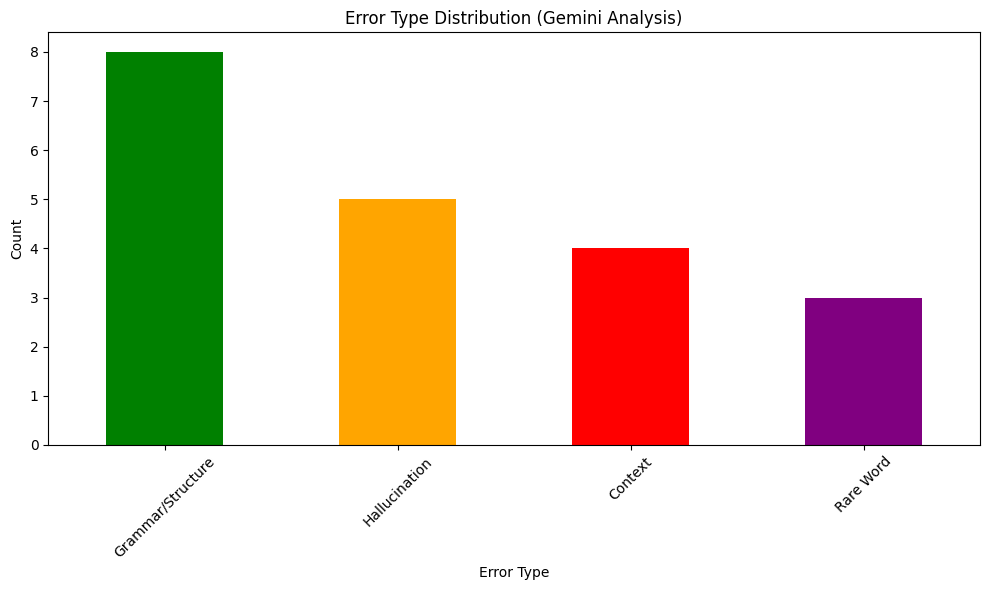


✅ Saved: /content/drive/MyDrive/NLP_final/NLP_Translation_Project/error_distribution.png


In [ ]:
# ===== CELL 6: ANALYZE ERROR DISTRIBUTION =====

error_types = [d['error_type'] for d in diagnoses]
error_counts = pd.Series(error_types).value_counts()

print("\n📊 Error Type Distribution:")
print(error_counts)

# Visualization
plt.figure(figsize=(10, 6))
error_counts.plot(kind='bar', color=['green', 'orange', 'red', 'purple', 'blue'])
plt.title('Error Type Distribution (Gemini Analysis)')
plt.xlabel('Error Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(f"{PROJECT_DIR}/error_distribution.png", dpi=300)
plt.show()

print(f"\n✅ Saved: {PROJECT_DIR}/error_distribution.png")


In [ ]:
# ===== CELL 7: GENERATE SYNTHETIC DATA (FIXED) =====

synthesis_prompt_template = """
You are a professional translation dataset creator.

Based on the error analysis, we need to generate NEW training examples to fix this weakness:
- Error type: {error_type}
- Missing element: {missing_element}

Generate {num_examples} NEW translation pairs ({direction}) that specifically address this weakness.

Requirements:
1. Must be realistic, natural sentences
2. Must contain the missing pattern/vocabulary/structure
3. Diverse topics and contexts
4. High quality translations

Respond in JSON format:
{{
  "examples": [
    {{"source": "...", "target": "..."}},
    {{"source": "...", "target": "..."}}
  ]
}}
"""

print("🔬 Generating synthetic data...")

# Group diagnoses by error type
error_groups = {}
for d in diagnoses:
    error_type = d['error_type']
    if error_type != 'None':
        if error_type not in error_groups:
            error_groups[error_type] = []
        error_groups[error_type].append(d)

print(f"\nFound {len(error_groups)} error types needing synthetic data")

synthetic_examples = []

for error_type, group in error_groups.items():
    print(f"\n  Generating for: {error_type} ({len(group)} issues)")

    representative = group[0]
    num_examples = min(len(group) * 50, 500)  # Max 500 per type

    prompt = synthesis_prompt_template.format(
        error_type=error_type,
        missing_element=representative['missing_element'],
        num_examples=num_examples,
        direction="both Vi→En and En→Vi"
    )

    try:
        response = gemini_model.generate_content(prompt)
        response_text = response.text.strip()


        if '```json' in response_text:
            try:
                response_text = response_text.split('```json', 1)[1].split('```', 1)[0].strip()
            except IndexError:
                print("    Warning: Malformed JSON block")
                response_text = response_text.split('```json', 1)[1].strip() if '```json' in response_text else response_text
        elif '```' in response_text:
            try:
                response_text = response_text.split('```', 1)[1].split('```', 1)[0].strip()
            except IndexError:
                print("    Warning: Malformed code block")
                response_text = response_text.split('```', 1)[1].strip() if '```' in response_text else response_text

        generated = json.loads(response_text)

        for ex in generated['examples']:
            synthetic_examples.append({
                'source': ex['source'],
                'target': ex['target'],
                'error_type': error_type,
                'direction': 'synthetic'
            })

        print(f"    Generated {len(generated['examples'])} examples")
        time.sleep(2)

    except Exception as e:
        print(f"    Error: {e}")

print(f"\n✅ Generated {len(synthetic_examples)} synthetic examples!")

# Save
synthetic_df = pd.DataFrame(synthetic_examples)
synthetic_df.to_csv(f"{PROJECT_DIR}/synthetic_data.csv", index=False)
print(f"💾 Saved to {PROJECT_DIR}/synthetic_data.csv")

🔬 Generating synthetic data...

Found 4 error types needing synthetic data

  Generating for: Grammar/Structure (8 issues)
    Error: Expecting value: line 475 column 130 (char 68885)

  Generating for: Hallucination (5 issues)
    Generated 300 examples

  Generating for: Rare Word (3 issues)
    Generated 150 examples

  Generating for: Context (4 issues)
    Generated 263 examples

✅ Generated 713 synthetic examples!
💾 Saved to /content/drive/MyDrive/NLP_final/NLP_Translation_Project/synthetic_data.csv


In [ ]:
# ===== CELL 8: CREATE BIDIRECTIONAL SYNTHETIC DATA =====

# Expand synthetic data to bidirectional
synthetic_bi_list = []

for _, row in synthetic_df.iterrows():
    # Vi→En
    synthetic_bi_list.append({
        'source': row['source'],
        'target': row['target'],
        'direction': 'vi2en'
    })
    # En→Vi (reverse)
    synthetic_bi_list.append({
        'source': row['target'],
        'target': row['source'],
        'direction': 'en2vi'
    })

synthetic_bi_df = pd.DataFrame(synthetic_bi_list)

print(f"✅ Created {len(synthetic_bi_df):,} bidirectional synthetic samples")

# Convert to HF Dataset
from datasets import Dataset

synthetic_dataset = Dataset.from_pandas(synthetic_bi_df, preserve_index=False)

# Save
synthetic_dataset.save_to_disk(f"{PROJECT_DIR}/dataset_synthetic")
print(f"💾 Saved to {PROJECT_DIR}/dataset_synthetic")


✅ Created 1,426 bidirectional synthetic samples


Saving the dataset (0/1 shards):   0%|          | 0/1426 [00:00<?, ? examples/s]

💾 Saved to /content/drive/MyDrive/NLP_final/NLP_Translation_Project/dataset_synthetic


In [ ]:
# ===== CELL 9: MERGE WITH BASELINE DATA =====

from datasets import load_from_disk, concatenate_datasets

# Load baseline
baseline_train = raw_datasets['train']

# Load synthetic
synthetic_train = load_from_disk(f"{PROJECT_DIR}/dataset_synthetic")

print(f"📊 Before merge:")
print(f"   Baseline: {len(baseline_train):,}")
print(f"   Synthetic: {len(synthetic_train):,}")

# Concatenate
augmented_train = concatenate_datasets([baseline_train, synthetic_train])

# Shuffle
augmented_train = augmented_train.shuffle(seed=42)

print(f"\n✅ After merge & shuffle:")
print(f"   Total: {len(augmented_train):,}")

# Create augmented dataset
augmented_datasets = DatasetDict({
    'train': augmented_train,
    'validation': raw_datasets['validation'],
    'test': raw_datasets['test']
})

# Save
augmented_datasets.save_to_disk(f"{PROJECT_DIR}/dataset_augmented")
print(f"\n💾 Saved to {PROJECT_DIR}/dataset_augmented")


📊 Before merge:
   Baseline: 20,000
   Synthetic: 1,426

✅ After merge & shuffle:
   Total: 21,426


Saving the dataset (0/1 shards):   0%|          | 0/21426 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/2000 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/2000 [00:00<?, ? examples/s]


💾 Saved to /content/drive/MyDrive/NLP_final/NLP_Translation_Project/dataset_augmented
